In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

# need to install Latex (msttcorefonts and texlive packages)
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_svmlight_file
import numpy as np
import pickle
import glob
import os

from matplotlib.ticker import MaxNLocator

from utils import unpickle_dir

LOG_SCALE = True

In [3]:
def color(n):
    if 'sgd' in n:
        return 'C0'
    if 'top' in n:
        return 'C4'
    if 'rand' in n:
        return 'C1'
    
def marker(n):
    if 'sgd' in n:
        return '.'
    if 'top' in n:
        return '*'
    if 'rand' in n:
        return 's'
    
def legend_order(enumeration):
    # order sgd, rand, top in the legend
    ordered = []
    enumeration = list(enumeration)
    for m in ["sgd", "rand", "top"]:
        for i, v in enumeration:
            if m in v:
                ordered.append((i,v))
                break
    return ordered

# epsilon

In [4]:
DIR = "../results/eps-par/"
runs = list(glob.glob(os.path.join(DIR, "*")))

eps_data = dict([(p.split('/')[-1], unpickle_dir(p)) for p in runs])
    

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


models: ['top10', 'sgd', 'rand10']
[1, 2, 3, 5, 8, 10, 12, 15, 18, 20, 22, 24]
stopping threshold 0.28267376250519427


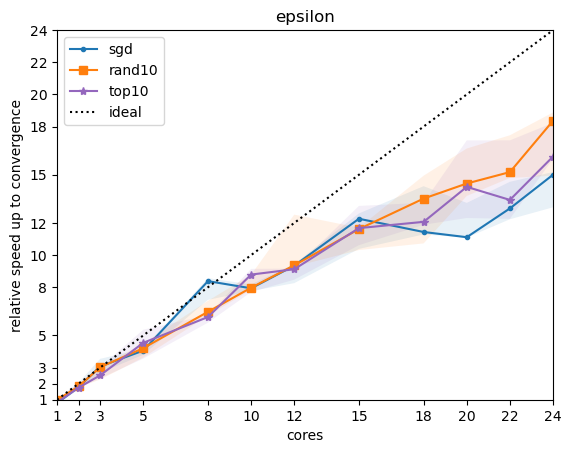

In [5]:
plt.rcParams['text.usetex'] = False

def epsilon_plot(ax, data):
    # put into one array (model, cores, timeserie)
    models = list(set([k.split('-')[0] for k in data.keys()]))
    print('models:', models)
    # models = ['rand10', 'top10', 'sgd']
    cores = sorted(list(set([int(k.split('-')[1][len('cores'):]) for k in data.keys()])))
    cores = [c for c in cores if c <= 24]
    print(cores)
    repeat = 3
    shape = [len(models), len(cores), repeat, len(data['rand10-cores1-0']['timers'])]
    iters = np.zeros(shape)
    losses = np.zeros(shape)
    timers = np.zeros(shape)

    for i, model in enumerate(models):
        for j, core in enumerate(cores):
            for k in range(repeat):
                name = "{}-cores{}-{}".format(model, core, k)
                datum = data[name]  # iters, loss, timers
                iters[i, j, k, :] = datum['iters']
                losses[i, j, k, :] = datum['losses']
                timers[i, j, k, :] = datum['timers']

    threshold = losses.min(axis=-1).max()
    print('stopping threshold', threshold)
    stop_iter = (losses <= threshold).argmax(axis=-1)
    chronos = np.zeros(stop_iter.shape)
    for i in range(len(models)):
        for j in range(len(cores)):
            for k in range(repeat):
                chronos[i,j,k] = timers[i,j,k,stop_iter[i, j, k]]

    chronos_sorted = np.sort(chronos, axis=-1)
    speedup = chronos_sorted[:, 0, 0, np.newaxis, np.newaxis] / chronos_sorted
    for i, model in legend_order(enumerate(models)):
        ax.plot(cores, speedup[i, :, 1], c=color(model), label=model, marker=marker(model))
        ax.fill_between(cores, speedup[i, :, 0], speedup[i, :, 2], facecolor=color(model), alpha=0.1)

    lim = [min(cores), max(cores)]
    ax.plot(lim, lim, linestyle=':', color="black", label="ideal")

    ax.legend()
    ax.set_title('epsilon')
    ax.set_xlabel('cores')
    ax.set_xlim(lim)
    ax.set_xticks(cores)
    ax.set_ylim(lim)
    ax.set_yticks(cores)
    ax.set_ylabel('relative speed up to convergence')

fig, ax = plt.subplots(1, 1)
epsilon_plot(ax, eps_data)

# RCV

In [6]:
pattern = "../results/rcv-par/*"
runs = list(glob.glob(pattern))

rcv_data = dict([(p.split('/')[-1], unpickle_dir(p)) for p in runs])

    

models: ['rand50', 'top50', 'sgd']
cores: [1, 2, 3, 5, 8, 10, 12, 15, 18, 20, 24]
stopping threshold 0.08501231692833965


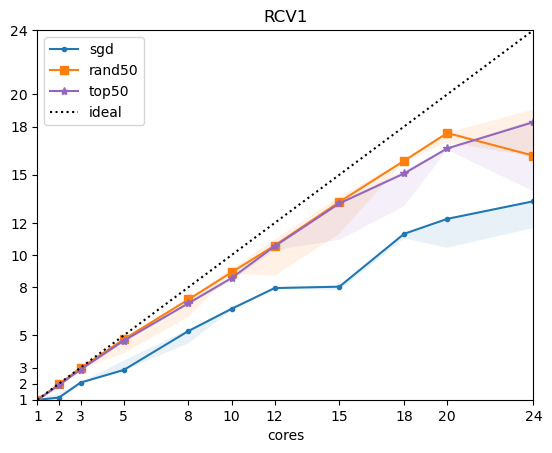

In [7]:
def rcv_plot(ax, data):
    models = list(set([k.split('-')[0] for k in data.keys()]))
    print('models:', models)
    cores = sorted(list(set([int(k.split('-')[1][len('cores'):]) for k in data.keys()])))
    print('cores:', cores)

    # models = ['rand10', 'top10', 'sgd']
    # cores = [1, 2, 3, 5, 10, 15, 18, 20, 25]
    repeat = 3
    length = len(data['{}-cores{}-0'.format(models[0], cores[0])]['timers'])
    length = length - (length % 10)
    shape = [len(models), len(cores), repeat, length]
    iters = np.zeros(shape)
    losses = np.zeros(shape)
    timers = np.zeros(shape)

    for i, model in enumerate(models):
        for j, core in enumerate(cores):
            for k in range(repeat):
                name = "{}-cores{}-{}".format(model, core, k)
                datum = data[name]  # iters, loss, timers
                iters[i, j, k, :] = datum['iters'][:length]
                losses[i, j, k, :] = datum['losses'][:length]
                timers[i, j, k, :] = datum['timers'][:length]

    threshold = losses.min(axis=-1).max()
    print('stopping threshold', threshold)
    stop_iter = (losses <= threshold).argmax(axis=-1)
    chronos = np.zeros(stop_iter.shape)
    for i in range(len(models)):
        for j in range(len(cores)):
            for k in range(repeat):
                chronos[i,j,k] = timers[i,j,k,stop_iter[i, j, k]]

    chronos_sorted = np.sort(chronos, axis=-1)
    speedup = chronos_sorted[:, 0, 0, np.newaxis, np.newaxis] / chronos_sorted
    for i, model in legend_order(enumerate(models)):
        c = "C{}".format(i)
        ax.plot(cores, speedup[i, :, 1], c=color(model), label=model, marker=marker(model))
        ax.fill_between(cores, speedup[i, :, 0], speedup[i, :, 2], facecolor=color(model), alpha=0.1)

    lim = [min(cores), max(cores)]
    ax.plot(lim, lim, linestyle=':', color="black", label="ideal")
    ax.set_xlim(lim)
    ax.set_xticks(cores)
    ax.set_ylim(lim)
    ax.set_yticks(cores)
    ax.legend()
    ax.set_title('RCV1')
    ax.set_xlabel('cores')
#     ax.set_ylabel('relative speed up to converge')
    
fig, ax = plt.subplots(1, 1)
rcv_plot(ax, rcv_data)

models: ['top10', 'sgd', 'rand10']
[1, 2, 3, 5, 8, 10, 12, 15, 18, 20, 22, 24]
stopping threshold 0.28267376250519427
models: ['rand50', 'top50', 'sgd']
cores: [1, 2, 3, 5, 8, 10, 12, 15, 18, 20, 24]
stopping threshold 0.08501231692833965


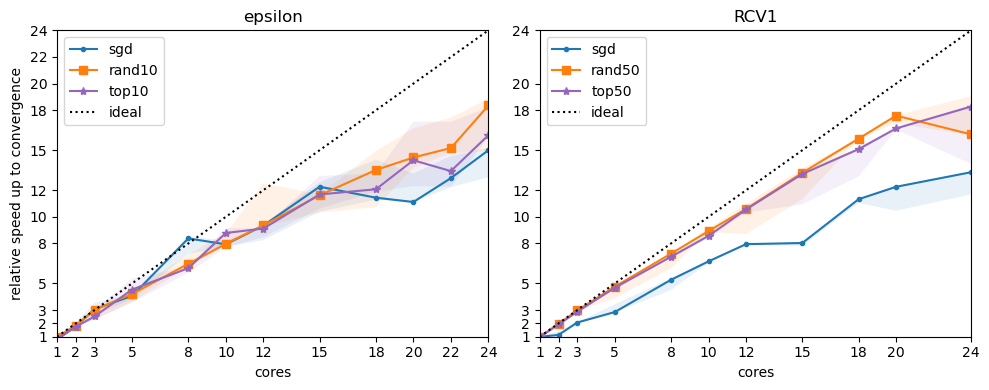

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
epsilon_plot(ax1, eps_data)
rcv_plot(ax2, rcv_data)
plt.tight_layout()
fig.savefig('../figures/speedup.pdf')